In [1]:
import sys
sys.path.append("..")

import Essentials


In [33]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

Загрузка данных

In [6]:
data_archive = np.load('..\Data_Average.npz', allow_pickle=True)

In [9]:
def prepare_Y(y):
    timestamp = y[:, 1]   
    y = y[:, 0].reshape(len(y), 1)
    y = y.astype(np.float64)

    return y, timestamp

Загрузка и подготовка данных. Сейчас классы построены таким образом, чтобы работать с numpy массивами X типа {N, C} и numpy массивами Y типа {N, 1}. Необходимо привести данные к такому виду для единнобразия обработки

N - количество точек, 
С - количестов каналов данных Х

In [10]:
X_test_1 = data_archive['X_test_1']
X_train_1 = data_archive['X_train_1']

X_test_2 = data_archive['X_test_2']
X_train_2 = data_archive['X_train_2']

X_test_3 = data_archive['X_test_3']
X_train_3 = data_archive['X_train_3']

Y_test_1, timestamp_test_1 = prepare_Y(data_archive['Y_test_1'])
Y_train_1, timestamp_train_1 = prepare_Y(data_archive['Y_train_1'])

Y_test_2, timestamp_test_2 = prepare_Y(data_archive['Y_test_2'])
Y_train_2, timestamp_train_2 = prepare_Y(data_archive['Y_train_2'])

Y_test_3, timestamp_test_3 = prepare_Y(data_archive['Y_test_3'])
Y_train_3, timestamp_train_3 = prepare_Y(data_archive['Y_train_3'])

In [100]:
X_train_1.shape

(57, 98)

In [107]:
class exp_layer(torch.nn.Module):
    def __init__(self, size_in):
        super().__init__()
        self.size = size_in
        self.weight = torch.nn.Parameter(torch.empty(size_in))
        torch.nn.init.normal_(self.weight)

    def forward(self, x):
        return torch.exp(self.weight*x)
        

In [136]:
class log_layer(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.log(torch.abs(x) + 1)
        

In [ ]:
# class inverse_layer(torch.nn.Module):
#     def __init__(self, size_in):
#         super().__init__()

#     def forward(self, x):
#         if torch.abs(x) > 0.0001:
#             return 1 / x
#         elif x >= 0:
#             return 10000
#         else:
#             return -10000
        

In [111]:
class multiply_layer(torch.nn.Module):
    def __init__(self, size_in):
        super().__init__()

    def forward(self, x1, x2):
        return x1 * x2

In [112]:
class pow_layer(torch.nn.Module):
    def __init__(self, size_in):
        super().__init__()
        self.size = size_in
        self.weight = torch.nn.Parameter(torch.empty(size_in))
        torch.nn.init.normal_(self.weight)

    def forward(self, x):
        return torch.pow(torch.abs(x)+0.0001, self.weight)
        

In [131]:
class const_layer(torch.nn.Module):
    def __init__(self, size_in):
        super().__init__()
        self.size = size_in
        self.weight = torch.nn.Parameter(torch.empty(size_in))
        torch.nn.init.normal_(self.weight)

    def forward(self, x):
        return x + self.weight
        

In [220]:
class nonlinear_model(torch.nn.Module):
    def __init__(self, size_data):
        super().__init__()
        self.exp = exp_layer(size_data)
        self.log = torch.nn.Sequential(const_layer(size_data), log_layer())
        self.pow = torch.nn.Sequential(const_layer(size_data), pow_layer(size_data))
        self.final = torch.nn.Linear(3*size_data, 1)

    def forward(self, x):
        # _exp = self.exp(x)
        _log = self.log(x)
        _pow = self.pow(x)
        res = torch.cat((x, _log, _pow), dim=1)
        # res = torch.cat((x, _e), dim=1)
        return self.final(res)

In [109]:
model = nonlinear_model

Parameter containing:
tensor([-0.9652, -0.5707], requires_grad=True)

In [110]:
model(torch.tensor([[0, 1], [2, 3]]))

tensor([[1.0000, 0.5651],
        [0.1451, 0.1805]], grad_fn=<ExpBackward0>)

In [84]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [86]:
x = torch.linspace(-10, 10, 1000)

In [88]:
y = -500 + torch.pow(2, x)

In [89]:
for i in range(500):
    optimizer.zero_grad()
    Y_pred = model(x)
    loss = criterion(Y_pred, y)
    loss.backward()
    optimizer.step()
    print(loss.item())

215444.484375
215431.5625
215418.75
215406.0625
215393.484375
215380.984375
215368.609375
215356.3125
215344.125
215332.0625
215320.109375
215308.25
215296.53125
215284.875
215273.359375
215261.9375
215250.640625
215239.421875
215228.34375
215217.34375
215206.46875
215195.703125
215185.046875
215174.46875
215164.03125
215153.65625
215143.421875
215133.28125
215123.265625
215113.3125
215103.484375
215093.765625
215084.109375
215074.5625
215065.140625
215055.8125
215046.578125
215037.40625
215028.375
215019.421875
215010.53125
215001.75
214993.0625
214984.5
214975.96875
214967.515625
214959.203125
214950.9375
214942.765625
214934.671875
214926.65625
214918.75
214910.890625
214903.140625
214895.4375
214887.84375
214880.296875
214872.828125
214865.40625
214858.109375
214850.859375
214843.6875
214836.59375
214829.53125
214822.59375
214815.65625
214808.828125
214802.0625
214795.359375
214788.703125
214782.125
214775.578125
214769.140625
214762.71875
214756.390625
214750.109375
214743.859375


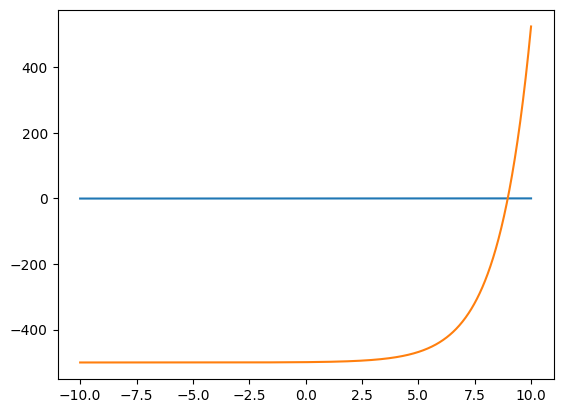

In [90]:
plt.plot(x, model(x).detach().numpy())
plt.plot(x, y)
plt.show()

In [43]:
plt.plot(x, y)

Parameter containing:
tensor([0.5803], requires_grad=True)

In [79]:
model.layer.bias

Parameter containing:
tensor([-0.1091], requires_grad=True)

In [11]:
X_test_1.shape

(74, 98)

In [214]:
class TestSoftSensor(Essentials.SoftSensor):
    def __init__(self, x_train, y_train):
        super().__init__('Test')
        self.x_scaler = StandardScaler() 
        self.y_scaler = StandardScaler()
        self.deleted_rows = None
        self.data_size = x_train.shape[1]
        self.fit_scaler(x_train, y_train)
        model = nonlinear_model(self.data_size)
        self.set_model(model)

        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        self.train(x_train, y_train)

    def prepocessing(self, x):
        try:
            trunc_x = np.delete(x, self.deleted_rows, 1)
            return torch.tensor(self.x_scaler.transform(trunc_x), dtype=torch.float32)
        except:
            try:
               return torch.tensor(self.y_scaler.transform(x), dtype=torch.float32)
            except BaseException as err:
                print("Ошибка скейлера")
                raise err
            
    def fit_scaler(self, x_train, y_train):
        self.x_scaler.fit(x_train)
        tmp = self.x_scaler.var_ < 0.01
        self.deleted_rows = [i for i, x in enumerate(tmp) if x]
        trunc_x = np.delete(x_train, self.deleted_rows, 1)
        self.x_scaler.fit(trunc_x)
        self.data_size = trunc_x.shape[1]
        
        self.y_scaler.fit(y_train)
    
    def postprocessing(self, x):
        try:
            x_post = x.detach().numpy()
            return self.x_scaler.inverse_transform(x_post)
        except:
            try:
                x_post = x.detach().numpy()
                return self.y_scaler.inverse_transform(x_post)
            except BaseException as err:
                print("Ошибка скейлера")
                raise err

    def evaluate_model(self, x):
        model = self.get_model()
        return model(x)


    def train(self, x_train, y_train):
        preproc_y = self.prepocessing(y_train)
        preproc_x = self.prepocessing(x_train)
        model = self.get_model()
        for i in range(1000):
            self.optimizer.zero_grad()
            Y_pred = model(preproc_x)
            loss =  self.criterion(Y_pred, preproc_y)
            loss.backward()
            self.optimizer.step()
            print(loss.item())
            
        self.set_model(model)


    def __str__(self):
        pass

Создаём экземпляр класса с нашим алгоритмом. Имеет смысл создать по экземпляру на каждый из рассматриваемых наборов данных, данные необходимые для создания определяются в методе __init__(), там же определяется некоторые опреации, выполняемые автоматически при создании (в данном случае имя железно прописано, не делайте так, + сразу оюучаются функции для предобработки)

In [221]:
Test_sensor_1 = TestSoftSensor(X_train_1, Y_train_1)

25795.078125
16329.2744140625
10695.3515625
7186.40234375
4873.90673828125
3266.129150390625
2273.907958984375
2915.90185546875
1866.8260498046875
1317.4517822265625
1056.8707275390625
901.060791015625
788.869873046875
699.9755859375
626.328125
563.9192504882812
510.3062438964844
463.8035888671875
423.1412353515625
387.31536865234375
355.5204162597656
327.0953369140625
301.5175476074219
278.322021484375
257.153076171875
237.77871704101562
220.0559844970703
203.98272705078125
189.7783660888672
178.01901245117188
169.76553344726562
166.31497192382812
167.15594482421875
167.14686584472656
162.3053436279297
154.32098388671875
146.15048217773438
139.35330200195312
134.16896057128906
130.26866149902344
127.22237396240234
124.69427490234375
122.46057891845703
120.38655090332031
118.39761352539062
116.45924377441406
114.55756378173828
112.6870346069336
110.84365844726562
109.01046752929688
107.16130065917969
105.2818603515625
103.36832427978516
101.44549560546875
99.55146026611328
97.724029541

Пример работы метода __str__. Функция print() выдаёт нужную строку, полезно для тестирования и наглядности

In [144]:
print(Test_sensor_1)

TypeError: __str__ returned non-string (type NoneType)

Создание экземпляра метрики, достаточно одного для тестирования

In [196]:
metric = Essentials.R2Metric()

Визуализация работы алгоритма, для этого необходимо создать экземпляр класса Visualizer из Essentials.py. При создании такого экземпляра необходимо задать тестовые значения и метки X (их мы загрузили заранее), необходимо создать такой экземпляр для каждого из набора данных

In [222]:
test_visual = Essentials.Visualizer(X_train_1, Y_train_1, timestamp_train_1, [metric], 'Test SoftSensor R2 metric')

      Coefficient of determination
Test                      0.759276


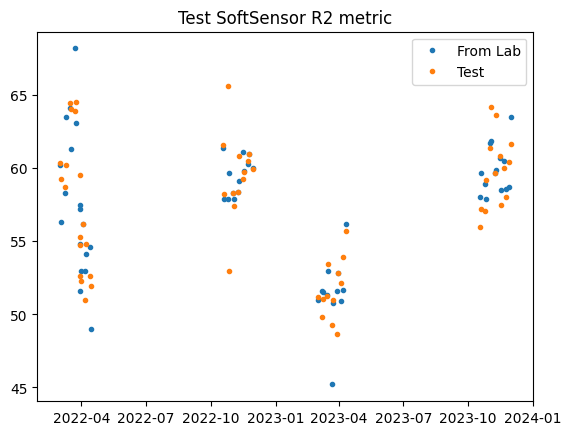

In [223]:
test_visual.visualize([Test_sensor_1])

На выходе получаем ожидаемую картинку. Тестовая модель выдаёт постоянные значения для любых Х. Значение метрики ожидаемо близко к 0 так как коэффициент детерминации сравнивает качество работы как раз со моделью среднего значения

На практике при работе в IDE рекомендуется сверху описать все необходимые классы, а тестирование производить нижу внутри конструкции 

if __name__ == '__main__':


Это точка входа в программу, которая выполняется только если запускается именно ваш файл и игнорируется, если файл импортируется. Это поможет нам избежать конфликтов и ненужных операции при импортировании моделей. Если ваша модель долго обучается, то имеет смысл описать методы save() и load() для загрузки заранее обученной модели.

In [224]:
test_visual_2 = Essentials.Visualizer(X_test_1, Y_test_1, timestamp_test_1, [metric], 'Test SoftSensor R2 metric')

      Coefficient of determination
Test                 -1.301004e+09


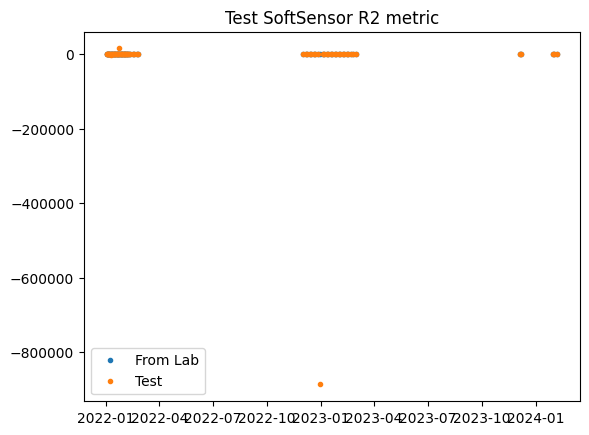

In [225]:
test_visual_2.visualize([Test_sensor_1])

In [124]:
arr = [True, False, True, False]

In [125]:
b = [i for i, x in enumerate(arr) if x]

In [126]:
np.delete(a, b, 1)

array([[1., 3.],
       [1., 3.]])

In [191]:
md = Test_sensor_1.get_model()

In [192]:
md(torch.tensor(np.delete(X_train_1, Test_sensor_1.deleted_rows, 1), dtype=torch.float32))

tensor([[206.3586],
        [209.1933],
        [245.0441],
        [218.5552],
        [213.0770],
        [235.5940],
        [216.6970],
        [235.8229],
        [290.2333],
        [319.6228],
        [355.7375],
        [373.8796],
        [344.0561],
        [320.8174],
        [330.6968],
        [325.0345],
        [263.6833],
        [224.2360],
        [270.4767],
        [231.5073],
        [242.3356],
        [258.8272],
        [259.7375],
        [238.5139],
        [253.6008],
        [236.1390],
        [244.8105],
        [216.0253],
        [259.0887],
        [235.7641],
        [244.3622],
        [228.1141],
        [274.1708],
        [232.4859],
        [292.3620],
        [271.9647],
        [269.3306],
        [256.0161],
        [241.3275],
        [267.2311],
        [260.1899],
        [281.8504],
        [263.4702],
        [289.0758],
        [276.4597],
        [266.4409],
        [267.7542],
        [268.5132],
        [271.0175],
        [248.6980],


In [193]:
list(md.parameters())

[Parameter containing:
 tensor([[ 0.0814, -0.1000,  0.0880,  0.0385,  0.1084, -0.0897,  0.0457, -0.0860,
          -0.0330,  0.0660,  0.0553,  0.0482, -0.0886, -0.0363,  0.0926, -0.0062,
           0.0085,  0.0384, -0.1069,  0.0165,  0.0965,  0.0860, -0.0332, -0.0979,
           0.0580,  0.0709,  0.0908,  0.0038, -0.0034, -0.0074,  0.0073, -0.0409,
          -0.0159,  0.1026, -0.0146,  0.0826, -0.0523, -0.0787,  0.1037, -0.0939,
          -0.0161, -0.0105, -0.0277,  0.0203,  0.0476, -0.0288, -0.0017,  0.0353,
           0.0020, -0.0876, -0.0312, -0.0244,  0.0857, -0.0365,  0.0488, -0.1020,
          -0.0404,  0.0295,  0.0542,  0.0307,  0.0020,  0.0449,  0.0226,  0.0313,
           0.0092,  0.1041,  0.0317, -0.0111,  0.0534, -0.0360,  0.0925,  0.0502,
          -0.0347, -0.0861, -0.0998, -0.0206,  0.0826, -0.0286, -0.0922, -0.0892,
          -0.1042, -0.0811,  0.0138, -0.0260]], requires_grad=True),
 Parameter containing:
 tensor([0.0801], requires_grad=True)]

In [190]:
Test_sensor_1.prepocessing(X_train_1)

tensor([[-0.0405, -0.4876, -1.7435,  ...,  0.4769, -0.3653, -0.4876],
        [ 0.0785, -0.4876, -1.3653,  ...,  0.4769,  0.1460,  0.0746],
        [ 0.2108, -0.4727, -1.3357,  ...,  0.4769,  0.1104,  0.0726],
        ...,
        [-0.3621, -0.2068,  0.9912,  ..., -0.8924,  0.4702,  0.6389],
        [-0.4305, -0.1447,  0.7104,  ..., -2.4863,  0.4595,  0.7332],
        [-0.2809, -0.2360,  0.9799,  ...,  0.2376,  0.4916,  0.7915]])